In [1]:
# Standard definitions needed for script
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import math
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from numpy.polynomial.polynomial import polyfit
import astropy.constants as const
from astropy.coordinates import Angle
import pickle

In [ ]:
# set-up for query to GAIA archive
from astroquery.gaia import Gaia
tables = Gaia.load_tables(only_names=True)
for table in (tables):
     print (table.get_qualified_name())
        
        
# send request to GAIA archive
# the items in the box command are (corrdinate system, RA in deg, Dec in 
#deg, box width in RA and Dec in deg)
query = "SELECT * \
FROM gaiadr2.gaia_source AS g, gaiadr2.tmass_best_neighbour AS tbest, gaiadr1.tmass_original_valid AS tmass \
WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid \
AND CONTAINS(POINT('ICRS',g.ra,g.dec),BOX('ICRS',277.49,-1.00,5.,5.))=1 AND (parallax >=1.6 AND parallax_over_error >=3);"

#old query
#gaiadr2.allwise_best_neighbour AS wbest \
#AND g.source_id = wbest.source_id \

job1 = Gaia.launch_job_async(query, dump_to_file=False)
GTab = job1.get_results() 
# this retrieves the result from the query above and puts into a table with the name "GTab"

#Save GAIA data to a file
file = 'GAIA_data.pkl'
data = {'GTab':GTab}
with open(file, 'wb') as f:
    pickle.dump(data,f, pickle.HIGHEST_PROTOCOL)

In [12]:
file = 'GAIA_data.pkl'
with open(file,'rb') as f: 
    data = pickle.load(f)
GTab = data['GTab']

print (GTab.colnames)
Gra = GTab["ra"]
Gdec = GTab["dec"]
Gpmra = GTab["pmra"]
Gpmra_e = GTab["pmra_error"]
Gpmdec = GTab["pmdec"]
Gpmdec_e = GTab["pmdec_error"]
Gpar = GTab["parallax"]
Gpar_sn = GTab["parallax_over_error"]
Gsepar = GTab["angular_distance"]
G2MASS = GTab["designation_2"]
g = GTab["phot_g_mean_mag"]
b = GTab["phot_bp_mean_mag"]
r = GTab["phot_rp_mean_mag"]
print(" GAIA Table contains ",len(Gra)," sources")

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

In [3]:
#calculate distance in pc and proper motion in km/s
Gdist = 1000./Gpar
Gpmra_km = (Gpmra*Gdist*const.au.value)/(u.yr.to('s')*1000.)
Gpmdec_km = (Gpmdec*Gdist*const.au.value)/(u.yr.to('s')*1000.)

Number of sources with parallax > 5, 10, 20:  19565 12758 8372


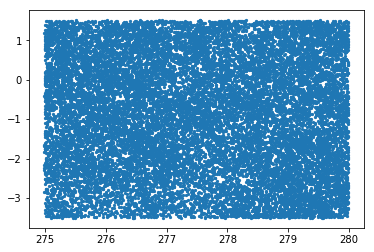

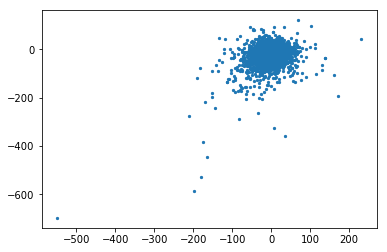

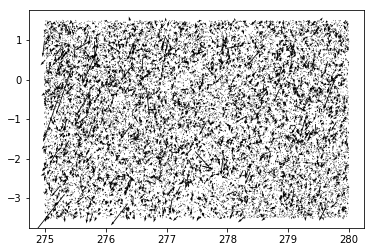

Mean proper motion (Ra,Dec):  -0.63988933166 -10.6697823303
Median proper motion (Ra,Dec):  0.670789726209 -7.1141171867


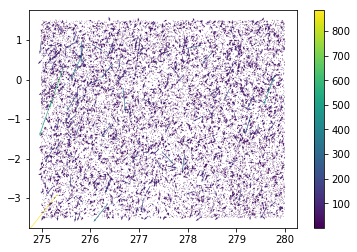

In [4]:
#Plots of GAIA sources

#find number of YSOs within parallax S/N greater than certain amount
parsn10 = Gpar_sn > 10.
parsn5 = Gpar_sn > 5
parsn20 = Gpar_sn > 20
print("Number of sources with parallax > 5, 10, 20: ", len(Gpar_sn[parsn5]),len(Gpar_sn[parsn10]),len(Gpar_sn[parsn20]))

#scatter plot of ra and dec
plt.scatter(Gra[parsn5],Gdec[parsn5],s=5)
plt.show()
#scatter plot of proper motions
plt.scatter(Gpmra[parsn5],Gpmdec[parsn5],s=5)
plt.show()
#plot of YSOs at ra and dec with proper motions
plt.quiver(Gra[parsn5],Gdec[parsn5],Gpmra[parsn5],Gpmdec[parsn5])
plt.show()

#mean proper motions
Gmean_pmra = np.mean(Gpmra[parsn10])
Gmean_pmdec = np.mean(Gpmdec[parsn10])
print("Mean proper motion (Ra,Dec): ",Gmean_pmra,Gmean_pmdec)
#median proper motions
Gmedian_pmra = np.median(Gpmra[parsn10])
Gmedian_pmdec = np.median(Gpmdec[parsn10])
print("Median proper motion (Ra,Dec): ",Gmedian_pmra,Gmedian_pmdec)
#deviation from median of proper motion  of S/N > 10 ysos
Grpmra = Gpmra - Gmedian_pmra
Grpmdec = Gpmdec - Gmedian_pmdec
#magnitude of deviation from median of proper motion
Gpmmag = np.zeros(len(Gra))
Gpmmag = np.power((Grpmra*Grpmra+Grpmdec*Grpmdec),0.5)
#plot of YSOs at ra and dec with deviation from median of proper motion
plt.quiver(Gra[parsn5],Gdec[parsn5],Grpmra[parsn5],Grpmdec[parsn5],Gpmmag[parsn5])
plt.colorbar()
plt.show()

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Warning: converting a masked element to nan.
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Warning: converting a masked element to nan.


Number of source matches in the correct distance interval:  14806
Number of sources with parallax > 5, 10, 20:  9287 6057 3823


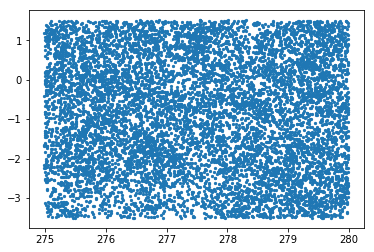

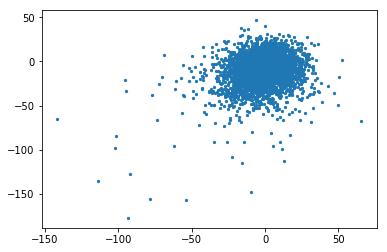

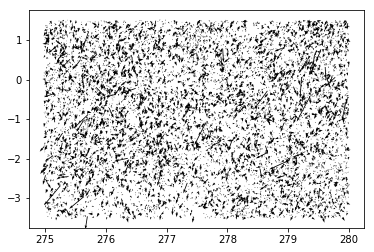

Mean proper motion (Ra,Dec):  -0.306653469216 -7.93435648589
Median proper motion (Ra,Dec):  0.914241370345 -6.85973872351


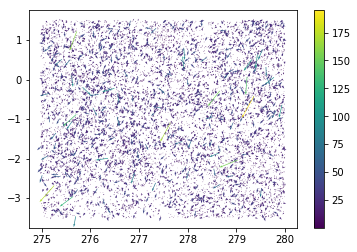

In [20]:
#Distance limited stars

#Distance Range
good_dist1 = (Gdist >= 350)
good_dist2 = (Gdist <= 550)
num_good_dist = len(Gdist[good_dist1 & good_dist2])

#Create arrays of values of stars within distance range
Dra = np.zeros(num_good_dist)
Ddec = np.zeros(num_good_dist)
Dpmra = np.zeros(num_good_dist)
Dpmdec = np.zeros(num_good_dist)
Dpmra_e = np.zeros(num_good_dist)
Dpmdec_e = np.zeros(num_good_dist)
Dpar = np.zeros(num_good_dist)
Dpar_sn = np.zeros(num_good_dist)
D_g = np.zeros(num_good_dist)
D_b = np.zeros(num_good_dist)
D_r = np.zeros(num_good_dist)
Dist = np.zeros(num_good_dist)

#find number of source matches in the correct interval
ns = 0
for i in range(0,len(Gra)):
        if(1000./Gpar[i] > 350. and 1000/Gpar[i] < 550.):
            Dra[ns] = Gra[i]
            Ddec[ns] = Gdec[i]
            Dpmra[ns] = Gpmra[i]
            Dpmdec[ns] = Gpmdec[i]
            Dpar[ns] = Gpar[i]
            Dpar_sn[ns] = Gpar_sn[i]
            D_g[ns] = g[i]
            D_b[ns] = b[i]
            D_r[ns] = r[i]
            Dist[ns] = Gdist[i]
            ns = ns + 1        
print("Number of source matches in the correct distance interval: ",ns)

#find number of YSOs within parallax S/N greater than certain amount
Dparsn10 = Dpar_sn > 10.
Dparsn5 = Dpar_sn > 5.
Dparsn20 = Dpar_sn > 20
print("Number of sources with parallax > 5, 10, 20: ", len(Dpar_sn[Dparsn5]),len(Dpar_sn[Dparsn10]),len(Dpar_sn[Dparsn20]))

#scatter plot of ra and dec
plt.scatter(Dra[Dparsn5],Ddec[Dparsn5],s=5)
plt.show()
#scatter plot of proper motions
plt.scatter(Dpmra[Dparsn5],Dpmdec[Dparsn5],s=5)
plt.show()
#plot of YSOs at ra and dec with proper motions
plt.quiver(Dra[Dparsn5],Ddec[Dparsn5],Dpmra[Dparsn5],Dpmdec[Dparsn5])
plt.show()

#mean proper motions
Dmean_pmra = np.mean(Dpmra[Dparsn10])
Dmean_pmdec = np.mean(Dpmdec[Dparsn10])
print("Mean proper motion (Ra,Dec): ",Dmean_pmra,Dmean_pmdec)
#median proper motions
Dmedian_pmra = np.median(Dpmra[Dparsn10])
Dmedian_pmdec = np.median(Dpmdec[Dparsn10])
print("Median proper motion (Ra,Dec): ",Dmedian_pmra,Dmedian_pmdec)
#deviation from median of proper motion  of S/N > 10 ysos
Drpmra = Dpmra - Dmedian_pmra
Drpmdec = Dpmdec - Dmedian_pmdec
#magnitude of deviation from median of proper motion
Dpmmag = np.zeros(num_good_dist)
Dpmmag = np.power((Drpmra*Drpmra+Drpmdec*Drpmdec),0.5)
#plot of YSOs at ra and dec with deviation from median of proper motion
plt.quiver(Dra[Dparsn5],Ddec[Dparsn5],Drpmra[Dparsn5],Drpmdec[Dparsn5],Dpmmag[Dparsn5])
plt.colorbar()
plt.show()

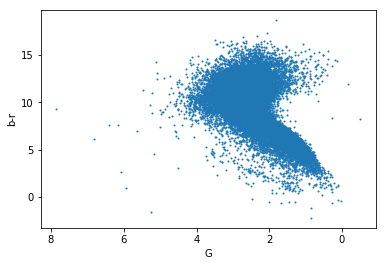

In [21]:
#HR Diagram plots

#calculate absolute magnitude for G

G = g - 5*np.log10(Gdist)+5

plt.scatter(b-r,G,s=1)
plt.gca().invert_xaxis()
plt.xlabel('G')
plt.ylabel('b-r')
plt.show()


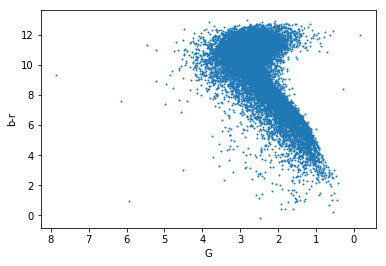

In [22]:
#HR Diagram plots

#calculate absolute magnitude for G

D_G = D_g - 5*np.log10(Dist)+5

plt.scatter(D_b-D_r,D_G,s=1)
plt.gca().invert_xaxis()
plt.xlabel('G')
plt.ylabel('b-r')
plt.show()